In [25]:
!pip install matplotlib
!pip install nibabel
!pip install scikit-image


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# DATASET
import nibabel as nib
import matplotlib.pyplot as plt

# Load the NIfTI file
data = nib.load("3702_left_knee.nii").get_fdata()

print(data.shape)

(512, 512, 216)


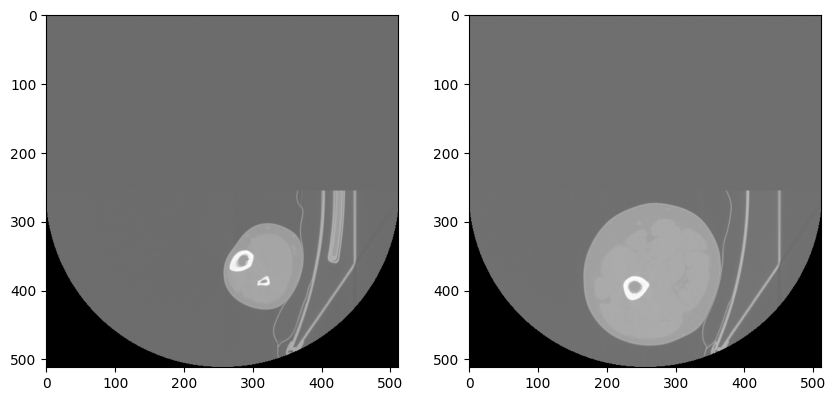

In [35]:
#VISUALIZATION OF DATASET

dt1 = data[:, :, 0]
dt2 = data[:, :, 215] 


plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(dt1, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(dt2, cmap = 'gray')
            
plt.show()

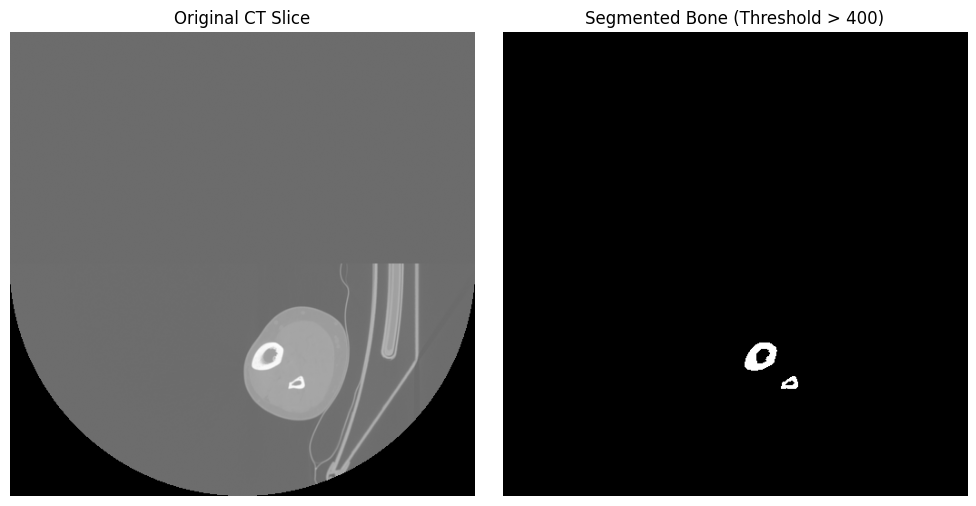

In [28]:
# BONE SEGMENTATION 

import numpy as np
import matplotlib.pyplot as plt

# Thresholding (for bone)
# Reference for selection of threshold : https://radiopaedia.org/articles/hounsfield-unit?lang=gb

# Parameters
segmentation_threshold = 400
index = 0


# Actual segmentation operation, which returns all values in Boolean
segmented_images = data > segmentation_threshold


# Sampling an image
original_image = data[:,:,index]
segmented_image = segmented_images[:,:,index]


# Display side-by-side
plt.figure(figsize=(10, 5))

# Original grayscale CT slice
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original CT Slice")
plt.axis('off')

# Segmented bone mask
plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Bone (Threshold > 400)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [29]:
from scipy.ndimage import label

# bone_mask is your thresholded mask (e.g., data > 700)
labeled_arrays, num_features = label(segmented_images)

print(f"Found {num_features} components")




Found 381 components


2
The Image is of Lower Leg, and contains tibula and fibula
{1: 655, 2: 165}
Maximum Area Component :  1  with area of :  655
Hence, component 1 is Tibula
(512, 512)
(512, 512, 3)


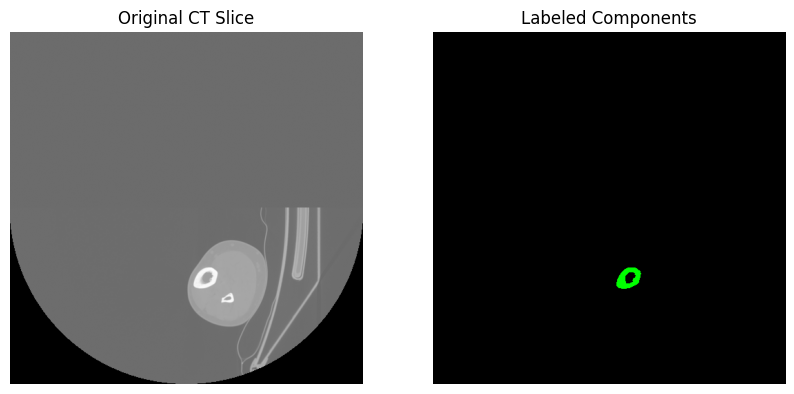

In [36]:
#TIBULA(GREEN) AND FEMUR SEGMENTATION(RED)

labeled_array, num_features = label(segmented_image)
binary_mask = labeled_array
print(num_features)


temparr1 = np.zeros((512,512), dtype = int)
temparr2 = np.zeros((512,512), dtype = int)


if num_features == 1:
    print('The Image is of Upper Leg and contains femur')
    area = {i : (labeled_array == i).sum() for i in range(1, num_features+1)}
    print(area)

    plt.figure(figsize=(10, 5))


    labeled_array = np.stack((labeled_array, temparr1, temparr2), axis = 2)
    labeled_array = labeled_array * 255

    
    plt.subplot(1, 2, 1)
    plt.imshow(data[:, :, index], cmap='gray')
    plt.title("Original CT Slice")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled_array, cmap='gray')  # Use colorful colormap
    plt.title("Labeled Components")
    plt.axis('off')
    
    plt.show()

else: 
    print('The Image is of Lower Leg, and contains tibula and fibula')
    area = {i : int((labeled_array == i).sum()) for i in range(1, num_features+1)}
    # checking area inorder to find tibula
    print(area)
    maximum_area = 0
    maximum_area_component = None
    for key, value in area.items():
        if value>maximum_area:
            maximum_area = value
            maximum_area_component = key
    print('Maximum Area Component : ', maximum_area_component,' with area of : ', maximum_area)
    print('Hence, component', maximum_area_component,'is Tibula')

    #Hiding fibula
    labeled_array[labeled_array != maximum_area_component] = 0

    print(labeled_array.shape)
    plt.figure(figsize=(10, 5))

    
    labeled_array = np.stack((temparr1, labeled_array, temparr2), axis = 2)
    labeled_array = labeled_array * 255
    print(labeled_array.shape)
    plt.subplot(1, 2, 1)
    plt.imshow(data[:, :, index], cmap='gray')
    plt.title("Original CT Slice")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled_array)  # Use colorful colormap
    plt.title("Labeled Components")
    plt.axis('off')
    
    plt.show()




In [31]:
area = [(labeled_array == i).sum() for i in range(1, num_features+1)]
# val = True
# print(int(val))
area

[np.int64(0), np.int64(0)]

In [37]:
#EXPANSION OF THE COUNTOUR OF MASK

import numpy as np
from skimage.morphology import binary_dilation, disk, ellipse
from skimage import measure

def expand_mask_by_mm(mask, spacing, expansion_mm=2.0):
    # Calculate number of pixels to match expansion_mm
    pixels_y = int(round(expansion_mm / spacing[0]))
    pixels_x = int(round(expansion_mm / spacing[1]))

    # Create an elliptical structuring element to match anisotropic spacing
    selem = ellipse(pixels_y, pixels_x)
    
    # Expand the mask
    expanded_mask = binary_dilation(mask, selem)
    return expanded_mask



(512, 512)


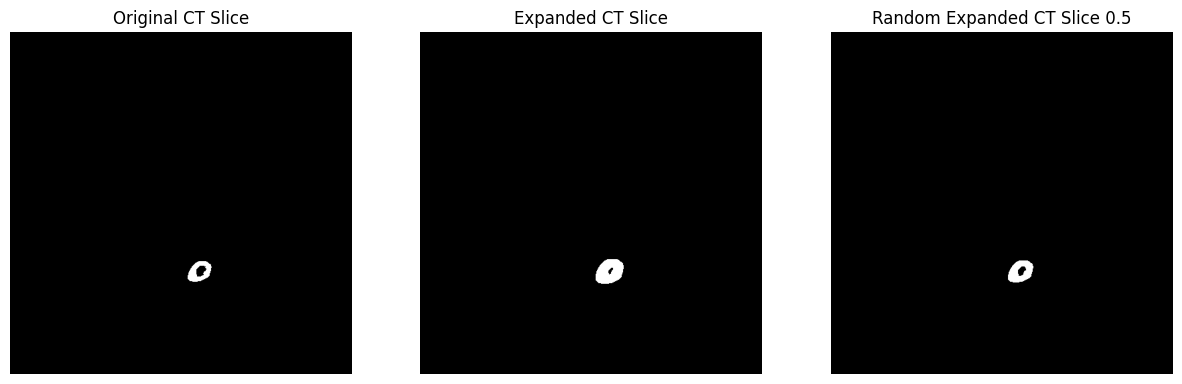

In [42]:
# Example binary mask and spacing (e.g., 0.5 mm/pixel)
# binary_mask = your binary mask
# spacing = (row_spacing_mm, col_spacing_mm), e.g. (0.7, 0.7)
# expansion_mm = 2.0
# random_level = 0.4 (40% of the way from original to full expansion)


spacing = (0.5, 0.5)  # (x, y) in mm/pixel



expanded = expand_mask_by_mm(binary_mask, spacing=(0.7, 0.7), expansion_mm=2.0)

ratio_of_expansion = 0.5

randomized = expand_mask_by_mm(binary_mask, spacing=(0.7, 0.7), expansion_mm=2.0 * ratio_of_expansion)
print(expanded.shape)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(binary_mask, cmap='gray')
plt.title("Original CT Slice")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(expanded, cmap='gray')  # Use colorful colormap
plt.title("Expanded CT Slice")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(randomized, cmap='gray')  # Use colorful colormap
plt.title(f"Random Expanded CT Slice {ratio_of_expansion}")
plt.axis('off')

plt.show()